In [1]:
import torch
from torch import nn
from d2l import torch as d2l

# 以dropout的概率丢弃张量输入X中的元素
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    # 在本情况中，所有元素都被丢弃
    if dropout == 1:
        return torch.zeros_like(X)
    # 在本情况中，所有元素都被保留
    if dropout == 0:
        return X
    mask = (torch.rand(X.shape) > dropout).float() # 从[0,1)的均匀分布取随机数，通过这种写法能够根据dropout概率随机位置生成0
    return mask * X / (1.0 - dropout) # 根据dropout概率随机位置变0，其余变大一点

In [32]:
# 测试一下dropout函数
X= torch.arange(16, dtype = torch.float32).reshape((2, 8))
print(X)
print(dropout_layer(X, 0.))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1.))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  0.,  0.,  0.,  0., 10., 12., 14.],
        [ 0., 18.,  0.,  0., 24., 26.,  0.,  0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


In [33]:
# 定义一个具有两个隐藏层的多层感知机，每个隐藏层包含256个单元。
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

## 定义模型

In [37]:
# 我们可以将暂退法应用于每个隐藏层的输出（在激活函数之后）， 并且可以为每一层分别设置暂退概率
# 常见的技巧是在靠近输入层的地方设置较低的暂退概率
dropout1, dropout2 = 0.2, 0.5

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,is_training = True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1) # 权重矩阵的尺寸：输出的维度 * 输入特征的维度
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()
    
    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        # 若在训练中，隐藏层进行dropout
        if self.training == True:
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2)
        return out

net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

## 训练与测试

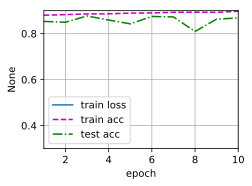

In [39]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss(reduction='none')
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

## 简洁实现

In [40]:
net = nn.Sequential(nn.Flatten(),
                   nn.Linear(784, 256), nn.ReLU(), nn.Dropout(dropout1),
                   nn.Linear(256, 256), nn.ReLU(), nn.Dropout(dropout2),
                   nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

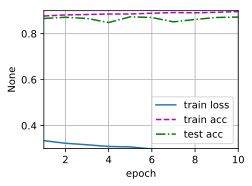

In [42]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction='none')
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)